In [2]:
import numpy as np
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, validation_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.decomposition import PCA

In [3]:
df_all = pd.read_parquet("../data/data_processed/participants/Participants_all.parquet")
df_all.head()

,pid,window_start,window_end,n_samples,duration_seconds,sex,age_group,label:Walmsley2020,label:Walmsley2020_enc,label:WillettsSpecific2018,...,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos
0,P001,2016-11-13 02:18:00,2016-11-13 02:18:05,500,4.99,1,2,sleep,3,sleep,...,0.432345,0.940507,0.969787,-0.148480,-0.077644,0.275487,0.0,0.0,0.566406,0.824126
1,P001,2016-11-13 02:18:05,2016-11-13 02:18:10,500,4.99,1,2,sleep,3,sleep,...,0.432585,0.942055,0.970582,-0.108382,-0.028882,0.137541,0.0,0.0,0.566706,0.823920
2,P001,2016-11-13 02:18:10,2016-11-13 02:18:15,500,4.99,1,2,sleep,3,sleep,...,0.432665,0.942753,0.970944,-0.260468,-0.079268,0.204062,0.0,0.0,0.567005,0.823714
3,P001,2016-11-13 02:18:15,2016-11-13 02:18:20,500,4.99,1,2,sleep,3,sleep,...,0.432626,0.941857,0.970483,-0.243211,-0.092415,0.223157,0.0,0.0,0.567305,0.823508
4,P001,2016-11-13 02:18:20,2016-11-13 02:18:25,500,4.99,1,2,sleep,3,sleep,...,0.433269,0.941597,0.970350,-0.225457,-0.079250,0.230302,0.0,0.0,0.567604,0.823302


## 1) Pequena análise exploratória das classes

In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843551 entries, 0 to 1843550
Data columns (total 37 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   pid                             object        
 1   window_start                    datetime64[ns]
 2   window_end                      datetime64[ns]
 3   n_samples                       int64         
 4   duration_seconds                float64       
 5   sex                             int64         
 6   age_group                       int64         
 7   label:Walmsley2020              object        
 8   label:Walmsley2020_enc          int64         
 9   label:WillettsSpecific2018      object        
 10  label:WillettsSpecific2018_enc  int64         
 11  label:WillettsMET2018           object        
 12  label:WillettsMET2018_enc       int64         
 13  x_mean                          float64       
 14  x_std                           float64       
 15

In [5]:
df_all.columns

Index(['pid', 'window_start', 'window_end', 'n_samples', 'duration_seconds',
       'sex', 'age_group', 'label:Walmsley2020', 'label:Walmsley2020_enc',
       'label:WillettsSpecific2018', 'label:WillettsSpecific2018_enc',
       'label:WillettsMET2018', 'label:WillettsMET2018_enc', 'x_mean', 'x_std',
       'x_min', 'x_max', 'y_mean', 'y_std', 'y_min', 'y_max', 'z_mean',
       'z_std', 'z_min', 'z_max', 'energy_x', 'energy_y', 'energy_z',
       'energy_total', 'magnitude_mean', 'corr_xy', 'corr_xz', 'corr_yz',
       'fft_dom_freq', 'fft_peak_power', 'hour_sin', 'hour_cos'],
      dtype='object')

In [6]:
df_all["label:WillettsSpecific2018"].value_counts().sort_values(ascending=False)

label:WillettsSpecific2018
sleep               680172
sitting             659391
household-chores    128905
walking             120096
mixed-activity       77226
vehicle              69478
standing             59762
manual-work          20055
bicycling            17933
sports               10533
Name: count, dtype: int64

In [7]:
df_all["label:WillettsSpecific2018"].value_counts(normalize=True).sort_values(ascending=False)

label:WillettsSpecific2018
sleep               0.368947
sitting             0.357674
household-chores    0.069922
walking             0.065144
mixed-activity      0.041890
vehicle             0.037687
standing            0.032417
manual-work         0.010878
bicycling           0.009727
sports              0.005713
Name: proportion, dtype: float64

In [8]:
dict_label_WillettsSpecific2018 = (df_all[['label:WillettsSpecific2018','label:WillettsSpecific2018_enc']]
                                   .drop_duplicates()
                                   .sort_values('label:WillettsSpecific2018_enc')
                                   .reset_index(drop=True))
dict_label_WillettsSpecific2018

,label:WillettsSpecific2018,label:WillettsSpecific2018_enc
0,bicycling,0
1,household-chores,1
2,manual-work,2
3,mixed-activity,3
4,sitting,4
5,sleep,5
6,sports,6
7,standing,7
8,vehicle,8
9,walking,9


In [9]:
#features baseadas em aceleração
features_acc = [
    'x_mean', 'x_std','x_min', 'x_max',
    'y_mean', 'y_std', 'y_min', 'y_max',
    'z_mean','z_std', 'z_min', 'z_max',
    'energy_x', 'energy_y', 'energy_z','energy_total',
    'magnitude_mean', 'corr_xy', 'corr_xz', 'corr_yz',
    'fft_dom_freq', 'fft_peak_power'
]

In [ ]:
#features não baseadas em aceleração
features_other = ['sex', 'age_group', 'hour_sin', 'hour_cos']

In [11]:
df_all[features_acc].isna().sum()

x_mean               0
x_std                0
x_min                0
x_max                0
y_mean               0
y_std                0
y_min                0
y_max                0
z_mean               0
z_std                0
z_min                0
z_max                0
energy_x             0
energy_y             0
energy_z             0
energy_total         0
magnitude_mean       0
corr_xy           7703
corr_xz           4398
corr_yz           4268
fft_dom_freq         0
fft_peak_power       0
dtype: int64

In [12]:
cols_corr = ["corr_xy", "corr_xz", "corr_yz"]
df_all[cols_corr] = df_all[cols_corr].fillna(0)

## Análise de PCA

/home/lianabernat/.pyenv/versions/wearable_project/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


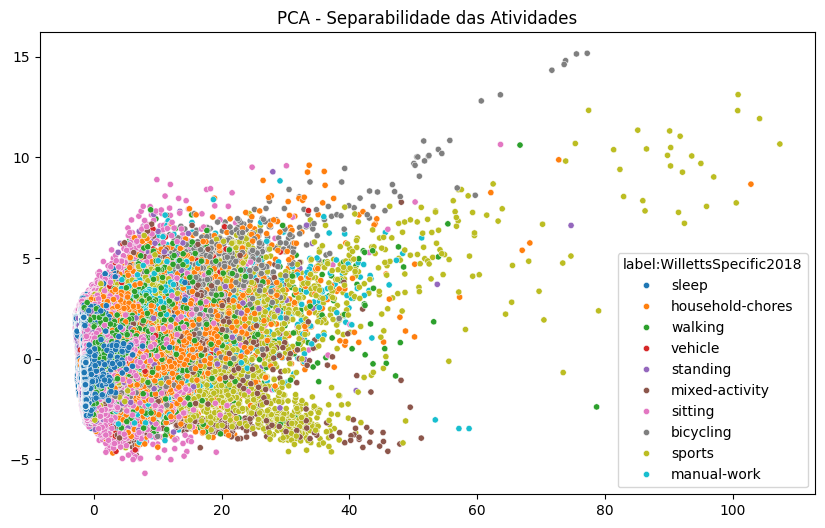

In [15]:
#Análise de PCA

X = df_all[features_acc]
y = df_all["label:WillettsSpecific2018"]

# Normalizar
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, s=20, palette="tab10")
plt.title("PCA - Separabilidade das Atividades")

plt.show()

In [11]:
X= df_all.drop(columns=['pid', 'window_start', 'window_end', 'n_samples', 'duration_seconds','sex', 'age_group', 'label:Walmsley2020', 'label:Walmsley2020_enc',
       'label:WillettsSpecific2018',  'label:WillettsSpecific2018_enc', 'label:WillettsMET2018', 'label:WillettsMET2018_enc'])
y=df_all['label:WillettsMET2018_enc']